In [1]:
import sys
import os

# Change directory to root
os.chdir('..')
# Add the parent directory of src to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

In [2]:
import json
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import log_loss, mean_absolute_error
from src.config import config

In [3]:
deep_palette = sns.color_palette("deep")
deep_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [4]:
# Configuration
DB_PATH = config["database"]["path"]

In [5]:
def fetch_predictor_data(seasons, predictors):
    """
    Fetches data from the database for the specified seasons and predictors.
    Args:
        seasons (list): List of seasons (e.g., ['2023-2024']).
        predictors (list): List of predictors (e.g., ['Baseline', 'Random']).
    Returns:
        DataFrame: Data containing game_id, predictor, prediction_set, home_score, away_score.
    """
    # Using a context manager for the database connection
    with sqlite3.connect(DB_PATH) as conn:
        # Define the SQL query
        query = f"""
        SELECT p.game_id, p.predictor, p.prediction_set, gs.home_score, gs.away_score
        FROM Predictions p
        JOIN Games g ON p.game_id = g.game_id
        JOIN GameStates gs ON p.game_id = gs.game_id AND gs.is_final_state = True
        WHERE g.season IN ({','.join('?' for _ in seasons)})
          AND p.predictor IN ({','.join('?' for _ in predictors)});
        """

        # Execute the query and load the data into a DataFrame
        df = pd.read_sql_query(query, conn, params=seasons + predictors)

    # Expand the JSON column 'prediction_set'
    df["prediction_set"] = df["prediction_set"].apply(json.loads)
    expanded_df = df.join(pd.json_normalize(df["prediction_set"]))

    # Drop the original 'prediction_set' column if no longer needed
    expanded_df = expanded_df.drop(columns=["prediction_set"])

    # Calculate actual_home_margin
    expanded_df["actual_home_margin"] = (
        expanded_df["home_score"] - expanded_df["away_score"]
    )

    # Assuming the JSON structure has keys like 'predicted_home_score' and 'predicted_away_score'
    expanded_df["pred_home_margin"] = (
        expanded_df["predicted_home_score"] - expanded_df["predicted_away_score"]
    )
    expanded_df["pred_home_win_pct"] = expanded_df["predicted_home_win_pct"]

    # Calculate actual_home_win_pct
    expanded_df["actual_home_win_pct"] = expanded_df.apply(
        lambda row: (
            1
            if row["home_score"] > row["away_score"]
            else (0 if row["home_score"] < row["away_score"] else 0.5)
        ),
        axis=1,
    )

    return expanded_df

In [6]:
def calculate_metrics(data):
    """
    Calculate Log Loss and MAE metrics for the given data.
    Args:
        data (DataFrame): Data containing actual and predicted values.
    Returns:
        dict: Dictionary of metrics for each predictor.
    """
    metrics = {}
    for predictor in data["predictor"].unique():
        df_pred = data[data["predictor"] == predictor]

        # Log Loss for home_win_pct
        log_loss_home_win_pct = log_loss(
            df_pred["actual_home_win_pct"], df_pred["pred_home_win_pct"]
        )

        # MAE for home_score, away_score, and margin
        mae_home_score = mean_absolute_error(
            df_pred["home_score"], df_pred["predicted_home_score"]
        )
        mae_away_score = mean_absolute_error(
            df_pred["away_score"], df_pred["predicted_away_score"]
        )
        mae_home_margin = mean_absolute_error(
            df_pred["actual_home_margin"], df_pred["pred_home_margin"]
        )

        metrics[predictor] = {
            "Log Loss (home_win_pct)": log_loss_home_win_pct,
            "MAE (home_score)": mae_home_score,
            "MAE (away_score)": mae_away_score,
            "MAE (home_margin)": mae_home_margin,
        }
    return metrics

In [7]:
def plot_metrics(metrics, save=False, image_filename=None):
    # Convert the metrics dictionary into a DataFrame and round values
    df = pd.DataFrame(metrics).T.round(2)
    df_unstacked = df.unstack().reset_index()
    df_unstacked.columns = ["Metric", "Predictor", "Value"]

    # Apply custom labels for the metrics
    custom_labels = {
        "Home Score MAE": "Home Score\nMAE",
        "Away Score MAE": "Away Score\nMAE",
        "Home Margin MAE": "Home Margin\nMAE",
        "Home Win Prob Log Loss": "Home Win %\nLog Loss",
    }
    df_unstacked["Metric"] = df_unstacked["Metric"].map(custom_labels)

    # Split DataFrame into MAE and Log Loss data
    mae_df = df_unstacked[df_unstacked["Metric"].str.contains("MAE")]
    log_loss_df = df_unstacked[df_unstacked["Metric"].str.contains("Log Loss")]

    # Generate custom color palette
    deep_palette = sns.color_palette("deep")
    custom_palette = {key: deep_palette[i] for i, key in enumerate(df_unstacked["Predictor"].unique())}
    custom_palette["MLP"] = deep_palette[0]
    custom_palette["Tree"] = deep_palette[2]
    custom_palette["Linear"] = deep_palette[1]
    custom_palette["Baseline"] = deep_palette[7]

    # Create subplots with recommended dimensions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={"width_ratios": [3, 1]})

    # Plot MAE metrics
    sns.barplot(data=mae_df, x="Metric", y="Value", hue="Predictor", ax=ax1, palette=custom_palette)
    ax1.set_ylabel("MAE (Points)", fontsize=18, fontweight="bold")
    ax1.tick_params(axis="y", labelsize=16)
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=18, fontweight="bold")
    ax1.grid(True)
    ax1.set_xlabel("")
    ax1.set_title("")
    ax1.xaxis.grid(False)

    # Annotate values on MAE bars
    for p in ax1.patches:
        value = p.get_height()
        if value > 0:
            ax1.text(
                p.get_x() + p.get_width() / 2,
                value - 0.8,
                f'{value:.2f}',
                ha="center",
                va="center",
                fontsize=14,
                weight='bold',
                color='white'
            )

    # Plot Log Loss metrics
    sns.barplot(data=log_loss_df, x="Metric", y="Value", hue="Predictor", ax=ax2, palette=custom_palette)
    ax2.set_ylabel("Log Loss", rotation=270, labelpad=24, fontsize=18, fontweight="bold")
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.tick_params(axis="y", labelsize=16)
    ax2.set_xticklabels(log_loss_df["Metric"], fontsize=18, fontweight="bold")
    ax2.grid(True)
    ax2.set_xlabel("")
    ax2.set_title("")
    ax2.xaxis.grid(False)

    # Annotate values on Log Loss bars
    for p in ax2.patches:
        value = p.get_height()
        if value > 0:
            ax2.text(
                p.get_x() + p.get_width() / 2,
                value - 0.04,
                f'{value:.2f}',
                ha="center",
                va="center",
                fontsize=14,
                weight='bold',
                color='white'
            )

    # Add a super title for the figure
    fig.suptitle("Prediction Engine Performance", fontsize=24, weight="bold", y=1)

    # Customize and add legend
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=len(df_unstacked["Predictor"].unique()),
        title="Predictors",
        bbox_to_anchor=(0.5, 0.95),
        fontsize=16,
        title_fontproperties={'weight': 'bold', "size": 18}
    )
    ax1.get_legend().remove()
    ax2.get_legend().remove()

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.90])

    # Save the plot to a file if requested
    if save and image_filename:
        plt.savefig(f"{image_filename}.png", dpi=300, bbox_inches="tight")
    
    # Display the plot
    plt.show()



In [8]:
metrics = {
    "Baseline": {
        "Home Win Prob Log Loss": 0.65,
        "Home Score MAE": 9.65,
        "Away Score MAE": 9.83,
        "Home Margin MAE": 11.61,
    },
    "Linear": {
        "Home Win Prob Log Loss": 0.62,
        "Home Score MAE": 9.47,
        "Away Score MAE": 9.46,
        "Home Margin MAE": 11.25,
    },
    "Tree": {
        "Home Win Prob Log Loss": 0.64,
        "Home Score MAE": 9.62,
        "Away Score MAE": 9.61,
        "Home Margin MAE": 11.30,
    },
    "MLP": {
        "Home Win Prob Log Loss": 0.63,
        "Home Score MAE": 9.41,
        "Away Score MAE": 9.45,
        "Home Margin MAE": 11.22,
    },
}

/tmp/ipykernel_14007/280756388.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=18, fontweight="bold")
/tmp/ipykernel_14007/280756388.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(log_loss_df["Metric"], fontsize=18, fontweight="bold")


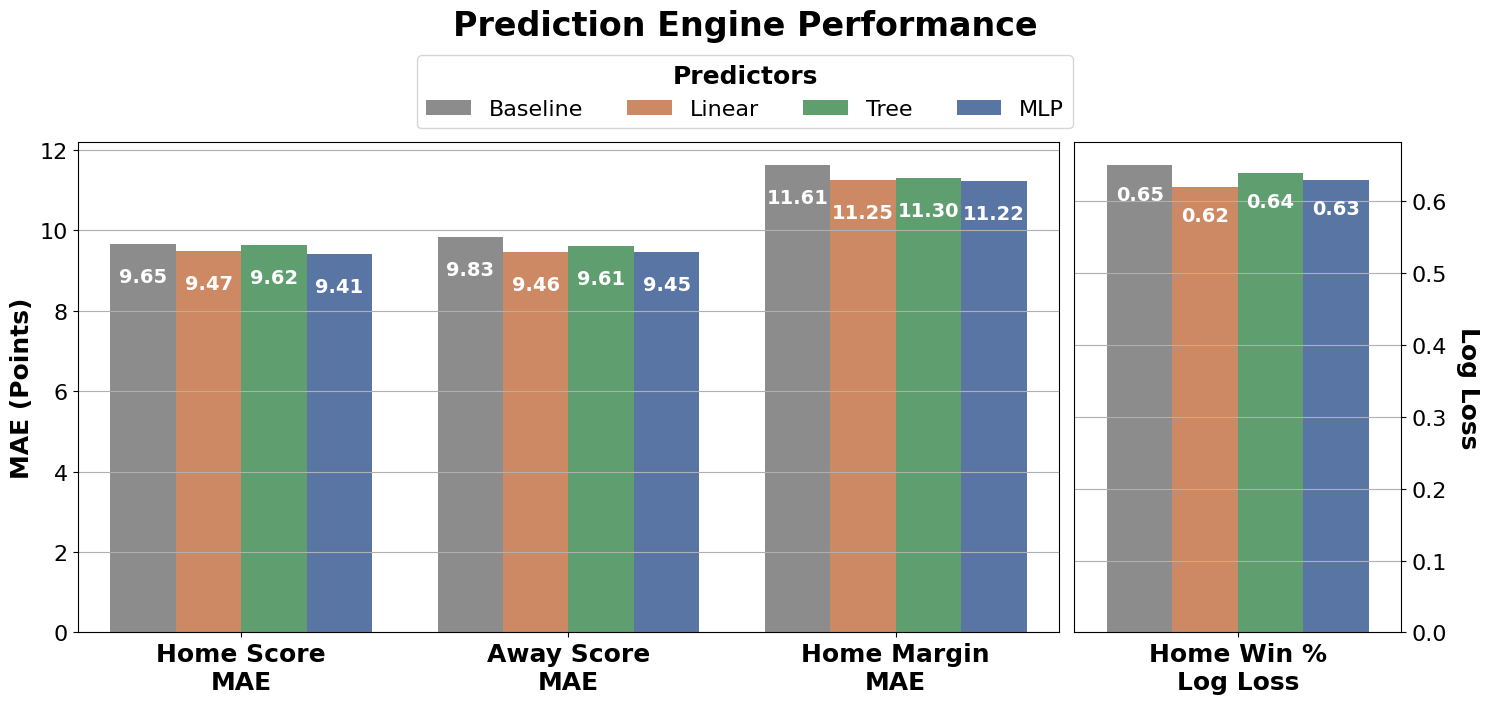

In [9]:
plot_metrics(metrics, save=True, image_filename="predictor_performance")